# Social Media Use and its Impact on Human Emotion
### Final Project for DTSA 5510: Unsupervised Algorithms in Machine Learning
#### University of Colorado, Boulder - Master of Science in Data Science

**By:** Andrea Francu  
**Version:** 1.0  
**Date:** December 19, 2024


This project uses a Kaggle dataset (https://www.kaggle.com/datasets/elvinrustam/wine-dataset?select=WineDataset.csv) that includes a variety of wine characteristics, such as region, cost, grape type, etc. The goal of this project is to use **Unsupervised Learning** methods to create clusters of different wines, which can then be used to make new wine recommendations.

In [ ]:
# Load in all necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

### Data loading & first look

In [2]:
wine_data = pd.read_csv('WineDataset.csv') # read in the csv
df = pd.DataFrame(wine_data) # convert the csv into a dataframe
df.head() # print first 5 lines of df

,Title,Description,Price,Capacity,Grape,Secondary Grape Varieties,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage,Appellation
0,"The Guv'nor, Spain",We asked some of our most prized winemakers wo...,£9.99 per bottle,75CL,Tempranillo,NaN,Natural Cork,Spain,10.5,"Vanilla, Blackberry, Blackcurrant",per bottle,Red,ABV 14.00%,NaN,Rich & Juicy,NV,NaN
1,Bread & Butter 'Winemaker's Selection' Chardon...,This really does what it says on the tin. It’s...,£15.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,USA,10.1,"Vanilla, Almond, Coconut, Green Apple, Peach, ...",per bottle,White,ABV 13.50%,California,Rich & Toasty,2021,Napa Valley
2,"Oyster Bay Sauvignon Blanc 2022, Marlborough",Oyster Bay has been an award-winning gold-stan...,£12.49 per bottle,75CL,Sauvignon Blanc,NaN,Screwcap,New Zealand,9.8,"Tropical Fruit, Gooseberry, Grapefruit, Grass,...",per bottle,White,ABV 13.00%,Marlborough,Crisp & Zesty,2022,NaN
3,Louis Latour Mâcon-Lugny 2021/22,We’ve sold this wine for thirty years – and fo...,£17.99 per bottle,75CL,Chardonnay,NaN,Natural Cork,France,10.1,"Peach, Apricot, Floral, Lemon",per bottle,White,ABV 13.50%,Burgundy,Ripe & Rounded,2022,Macon
4,Bread & Butter 'Winemaker's Selection' Pinot N...,Bread & Butter is that thing that you can coun...,£15.99 per bottle,75CL,Pinot Noir,NaN,Natural Cork,USA,10.1,"Smoke, Black Cherry, Cedar, Raspberry, Red Fruit",per bottle,Red,ABV 13.50%,California,Smooth & Mellow,2021,Napa Valley


In [3]:
df.info() # print out some information about the df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1290 entries, 0 to 1289
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Title                      1290 non-null   object 
 1   Description                1286 non-null   object 
 2   Price                      1290 non-null   object 
 3   Capacity                   1290 non-null   object 
 4   Grape                      1275 non-null   object 
 5   Secondary Grape Varieties  488 non-null    object 
 6   Closure                    1279 non-null   object 
 7   Country                    1284 non-null   object 
 8   Unit                       1281 non-null   float64
 9   Characteristics            1253 non-null   object 
 10  Per bottle / case / each   1290 non-null   object 
 11  Type                       1285 non-null   object 
 12  ABV                        1281 non-null   object 
 13  Region                     1124 non-null   objec

_____
## Exploratory Data Analysis (EDA)

### Features
There are 17 different factors which describe features of each wine: 

`Title`: Name of the wine\
`Description`: Text description of the wine, similar to a review\
`Price`: Cost of the wine\
`Capacity`: Volume of the wine bottle\
`Grape`: Type of grape used to make the wine (i.e. Pinot Noir, Tempranillo)\
`Secondary Grape Varieties`: Secondary grape used to make the wine\
`Closure`: Closure used for the bottle (i.e. natural cork, screwcap)\
`Country`: Country the wine was made in\
`Unit`: Measure of pure alcohol level, calculated by: $$ \frac{ABV(\%) \times Volume(mL)}{1000} = units $$
`Characteristics`: Lists flavor/aroma notes (i.e. peach, cherry)\
`Per bottle / case / each`: Unit associated with the price\
`Type`: Type of wine (i.e. red, white)\
`ABV`: Alcohol by volume\
`Region`: Region the grapes were grown\
`Style`: 2 words to describe overall characteristics of the wine\
`Vintage`: Year the grapes were harvested\
`Appellation`: Legally defined region where grapes were grown

From this initial look at the different features, it's likely that `Type` and `Grape` will be large factors in clustering. `Country` / `Region`, as well as `Characteristics` and `Style`, will likely also play a big role in how the different wines are clustered. It's likely that `Price` and `Closure` will be related, as screwcap bottles are generally cheaper than bottles with natural cork. `Price` will also likely be inversely linked to `Vintage`, as older wine is typically more expensive. `ABV` and `Unit` have a known linear relationship and may create some redundancy.

There is some data cleaning that needs to be done first. It appears that there are some null entries in a few of the categories, like `Secondary Grape Varities` and `Appellation`. It also looks like all but one of the variables are objects, even though some of them should probably be treated as floats, like `Price` and `ABV`. 
____
### Handling Null Entries
There are two main categories with significant null entries: `Secondary Grape Varieties` and `Appellation`. Since only about a third of the wine entries have `Secondary Grape Varieties` value, it's best to simply remove this category. Another route that could have been chosen for handling this variable is to set that column to a binary value, 1 if the wine has a secondary grape variety at all, and 0 if it does not. However, we do not know what other factors played into this column having a value in it. It is possible that many of the wines do have a secondary grape, but they just do not have an entry in the column. For this reason, it's best to just omit the column as a whole. 

Secondly, `Appellation` of a wine is the legally defined area where the grapes were grown. This value is only filled out for about half the wines, even though they all should technically have a value for this. We do also have the categories `Country` and `Region`, which give information about where the grape was grown, so we can remove the `Appellation` category.

In [4]:
df.drop(['Appellation', 'Secondary Grape Varieties'], axis = 1, inplace = True) # remove the 2 columns with mostly null values

______
## Data Cleaning - Numeric Features
#### Price and Per Bottle / Case / Each
Looking at price, it appears that the prices are formatted in pounds per bottle / case / each, but there is already another category for `Per bottle / case / each`. 'Per bottle' and 'each' can be assumed to mean the same thing. 'Per case' is a bit trickier, as a case of wine is typically 12 bottles, but this is not always the case (no pun intened). Some higher end wine comes in cases of 6 bottles. Looking at the entries set to 'per case', it looks like those rows are filled almost completely with NaNs. There's also only 6 entries with this value, so its best to just remove them. Afterwards, the pound sign and 'per bottle' / 'per case' strings can be removed from those entries, as everything left will be in pounds per bottle.

In [5]:
df['Price'].value_counts() # unique values in Price column

Price
£11.99 per bottle     100
£14.99 per bottle      96
£9.99 per bottle       91
£13.99 per bottle      77
£16.99 per bottle      67
                     ... 
£70.00 per bottle       1
£265.00 per bottle      1
£210.00 per bottle      1
£41.99 per bottle       1
£40.00 per bottle       1
Name: count, Length: 128, dtype: int64

In [6]:
df[df['Per bottle / case / each'] == 'per case'] # rows with this column set to 'per case'

,Title,Description,Price,Capacity,Grape,Closure,Country,Unit,Characteristics,Per bottle / case / each,Type,ABV,Region,Style,Vintage
104,Rosé Classics 6 Bottle Wine Case,Rosé wine is perfect for when the sun comes ou...,£79.00 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Rosé,NaN,NaN,NaN,NaN
295,The Guv'nor VIP 6 Bottle Taster Case,NaN,£49.00 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Red,NaN,NaN,NaN,NaN
298,The Guv'nor VIP 6 Bottle Wine Case,Just when you thought all the rules were broke...,£59.94 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Red,NaN,NaN,NaN,NaN
422,Festive French Classics 12 Bottle Mixed Wine Case,Discover favourites from France's iconic wine ...,£120.00 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Mixed,NaN,NaN,NaN,NaN
458,Majestic Classics 12 Red Wine Case,"A varied selection of delicious red wines, per...",£90.00 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Red,NaN,NaN,NaN,NaN
460,The Guv'nor Red 6 Bottle Wine Case,A firm Majestic favourite. Pick up this case t...,£44.94 per case,Our,NaN,NaN,NaN,NaN,NaN,per case,Red,NaN,NaN,NaN,NaN


In [7]:
df = df[df['Per bottle / case / each'] != 'per case'] # remove rows with 'per case'
df['Per bottle / case / each'].value_counts() # check value counts again

Per bottle / case / each
per bottle    1279
each             5
Name: count, dtype: int64

In [8]:
df.loc[:, 'Price'] = df['Price'].str.replace('£', '') # remove pound symbol from price, as all entries are in the same unit
df.loc[:, 'Price'] = df['Price'].str.replace(' per bottle', '') # remove text from price, as all entries are in the same unit
df.loc[:, 'Price'] = df['Price'].str.replace(' each', '') # remove text from price

df['Price'] = df['Price'].astype('float64') # cast to a float
df['Price'].value_counts() # look at inidividual values again, should all be numbers

Price
11.99     100
14.99      96
9.99       91
13.99      77
16.99      67
         ... 
41.99       1
135.00      1
80.00       1
33.00       1
40.00       1
Name: count, Length: 120, dtype: int64

In [9]:
# 'Per bottle / case / each' column is now redundant since all prices are in £ / bottle
df.drop('Per bottle / case / each', axis = 1, inplace = True) # remove the feature

#### Capacity
Another feature that needs to be converted to common units is  `Capacity`. This is the volume of the wine bottle. It looks like most of the values are in CL (centiliter). The other values can be converted into this unit.

In [10]:
df['Capacity'].value_counts() # check unique values of 'Capacity'

Capacity
75CL      1193
37.5CL      23
750ML       18
1.5LTR      18
150CL       11
50CL         8
2.25L        4
70CL         3
500ML        3
300CL        1
5LITRE       1
375ML        1
Name: count, dtype: int64

In [11]:
# convert everything to cl; 1 l = 100 cl, 10 ml = 1 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('750ML', '75') # 750 ml = 75 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('1.5LTR', '150') # 1.5 l = 150 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('2.25L', '225') # 2.25 l = 225 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('500ML', '50') # 500 ml = 50 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('5LITRE', '500') # 5 l = 500 cl
df.loc[:, 'Capacity'] = df['Capacity'].str.replace('375ML', '37.5') # 375 ml = 37.5 cl

df.loc[:, 'Capacity'] = df['Capacity'].str.replace('CL', '') # once everything is in centiliters, remove 'CL'

df['Capacity'] = df['Capacity'].astype('float64') # cast to a float
df['Capacity'].value_counts() # check value counts, should all be numbers

Capacity
75.0     1211
150.0      29
37.5       24
50.0       11
225.0       4
70.0        3
300.0       1
500.0       1
Name: count, dtype: int64

#### ABV and Unit
Another category that would be more useful if treated as an integer, is `ABV`. This is the Alcohol By Volume, and is a percent of the volume of wine that is alcohol.

In [12]:
df['ABV'].value_counts()

ABV
ABV 13.50%    249
ABV 13.00%    231
ABV 14.00%    188
ABV 14.50%    178
ABV 12.50%    174
ABV 12.00%    111
ABV 15.00%     45
ABV 11.00%     25
ABV 11.50%     16
ABV 20.00%     13
ABV 15.50%      8
ABV 16.00%      4
ABV 20.50%      4
ABV 9.50%       4
ABV 10.50%      3
ABV 0.50%       3
ABV 8.00%       3
ABV 14.40%      3
ABV 40.00%      2
ABV 19.00%      2
ABV 8.50%       2
ABV 10.00%      2
ABV 18.00%      1
ABV 14.20%      1
ABV 13.10%      1
ABV 17.50%      1
ABV 17.00%      1
ABV 18.50%      1
ABV 13.80%      1
ABV 5.00%       1
ABV 4.90%       1
ABV 12.90%      1
ABV 14.60%      1
Name: count, dtype: int64

It appears that all `ABV` entries have the format: ABV XX.XX%. Therefore, we can remove the 'ABV' and the '%' and cast to a float.

In [13]:
df.loc[:, 'ABV'] = df['ABV'].str.replace('ABV ', '') # remove ABV
df.loc[:, 'ABV'] = df['ABV'].str.replace('%', '') # remove %

df['ABV'] = df['ABV'].astype('float64') # cast to a float

Since `Unit` is derived from `ABV` and `Capacity`, this feature should be removed, as keeping it would create redundancy which could cause multicollinearity. This feature doesn't give us any new information, and its best to keep `ABV` and `Capacity` as those unique provide insight.

In [14]:
df.drop(['Unit'], axis = 1, inplace = True) # remove the column

#### Vintage
Looking at the `Vintage` category, there are a few entries that prevent casting to a float right away. First, there are entries with 'NV' (Not Vintage) rather than a year. To handle this, these can be changed to 2024. There are also a few entries with slashes in them, like '2020/21', or '2021/2022'. To handle these, we can remove the slash and anything that comes after.

In [15]:
df['Vintage'].value_counts() # check value counts of 'Vintage'

Vintage
2022         318
2021         261
2020         194
NV           171
2019         101
2018          69
2017          45
2016          22
2015          19
2014          17
2023          12
2013          10
2012           9
2008           6
2010           5
2007           3
2020/21        3
2011           3
2021/2022      2
2021/22        2
2005           2
2012/2015      1
2020/2022      1
2016/7         1
2019/20        1
1999           1
2003           1
2002           1
2020/2021      1
2009           1
Name: count, dtype: int64

In [16]:
df.loc[:, 'Vintage'] = df['Vintage'].str.replace('NV', '2024') # convert NV to 2024
df.loc[:, 'Vintage'] = df['Vintage'].str.split('/').str[0] # remove everything after /
df['Vintage'] = df['Vintage'].astype('float64') # convert to float
df['Vintage'].value_counts() # check value counts, should all be numbers

Vintage
2022.0    318
2021.0    265
2020.0    199
2024.0    171
2019.0    102
2018.0     69
2017.0     45
2016.0     23
2015.0     19
2014.0     17
2023.0     12
2012.0     10
2013.0     10
2008.0      6
2010.0      5
2007.0      3
2011.0      3
2005.0      2
1999.0      1
2003.0      1
2002.0      1
2009.0      1
Name: count, dtype: int64

One final modification that needs to be done is to remove columns with `None` values in them. For now, this will only be done for the **numeric** features, as these `None` values will prevent some of the plotting and transformation methods. 

In [17]:
df = df.dropna(subset = ['Price', 'Capacity', 'ABV', 'Vintage']) # drop the rows with null values in these columns

____
### Correlation - Numeric Features
Now that all the numeric features are actually being treated as numbers, we can get an idea of the correlation between these features with a correlation matrix heatmap.

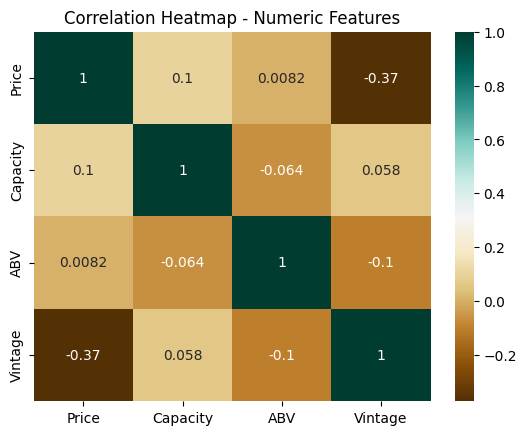

In [18]:
df_num = df.select_dtypes(include = 'float64') # make a df of the numeric features, only for plotting purposes
corr_matrix = df_num.corr() # make a correlation matrix of these features

# create a heatmap from the correlation matrix
plt.figure()
sns.heatmap(corr_matrix, annot = True, cmap = 'BrBG')
plt.title('Correlation Heatmap - Numeric Features')
plt.show()

This heatmap confirms that `Vintage` and `Price` do have a negative correlation. This makes sense, since older wines are typically more expensive. This is not a huge correlation, however, and both of these features do bring new insights into the data, so it is worth keeping them both. Other than this relationship, the rest of the correlation coefficients are relatively small.
___
### Feature Spread - Numeric Features
We can also take a look now at the spread of these numeric features and figure out if any transformation needs to be done on the features.

Text(0.5, 0.98, 'Distribution of Numeric Features - Boxplots')

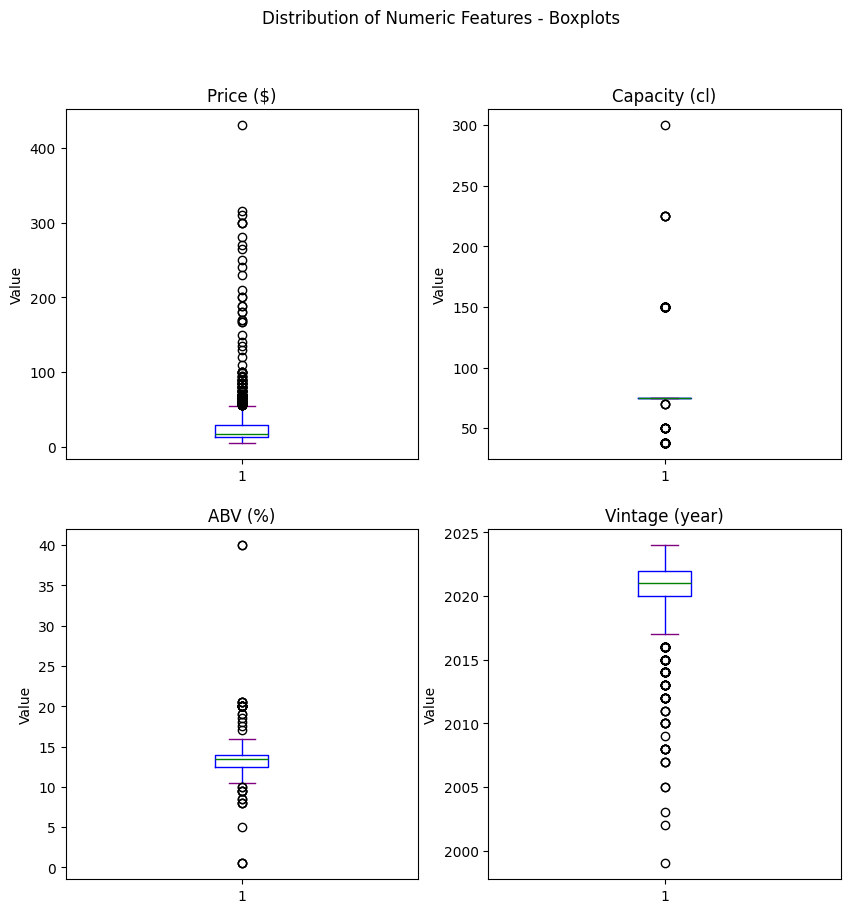

In [19]:
units = {       # make a dictionary of units to put in the title of the plots
    'Price': '($)',
    'Capacity': '(cl)',
    'ABV': '(%)',
    'Vintage': '(year)'
}

fig, axes = plt.subplots(2, 2, figsize = (10, 10)) # 4 plots for 4 numeric features
axes = axes.flatten()

for i, col in enumerate(df_num.columns):   # make boxplots for numeric features
    axes[i].boxplot(df_num[col], boxprops = dict(color = 'blue'), whiskerprops = dict(color = 'blue'),
                   capprops = dict(color = 'purple'), medianprops = dict(color = 'green'))
    axes[i].set_title(f"{col} {units.get(col, 'units')}")
    axes[i].set_ylabel('Value')
    
fig.suptitle('Distribution of Numeric Features - Boxplots')

Text(0.5, 0.98, 'Distribution of Numeric Features - Histograms')

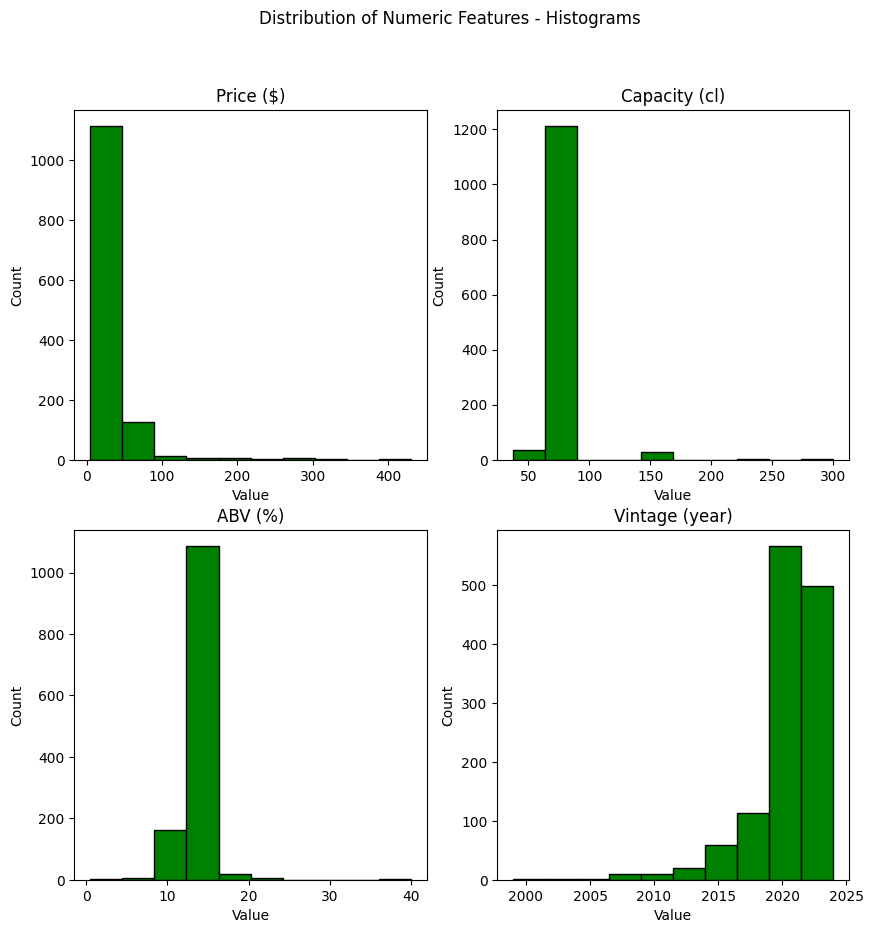

In [20]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10)) # 4 plots for 4 numeric features
axes = axes.flatten()

for i, col in enumerate(df_num.columns):   # make histograms for numeric features
    axes[i].hist(df_num[col], bins = 10, color = 'green', edgecolor = 'black')
    axes[i].set_title(f"{col} {units.get(col, 'units')}")
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Value')

fig.suptitle('Distribution of Numeric Features - Histograms')

In [21]:
num_metrics = pd.DataFrame({ # make a df with the min, max, and mean of each numeric feature
    'Min': df_num.min(),
    'Max': df_num.max(),
    'Mean': df_num.mean()
})

num_metrics

,Min,Max,Mean
Price,4.99,430.0,28.428664
Capacity,37.50,300.0,76.414062
ABV,0.50,40.0,13.426797
Vintage,1999.00,2024.0,2020.398438


### Skewness Analysis & Transformations
It appears that none of these numeric features have a normal distribution, and are all skewed left or right. One possible reason for this is the number of data points. But the nature of wine also plays a role in these distributions. `Price` and `Vintage` skew towards cheaper and less vintage wine. This is likely due to the fact that vintage wine is more rare, which drives up the price,  but this can also make it harder to find data on. `ABV` and `Capacity` both skew left of their mean. Looking at the values, this makes sense as the larger `ABV` (40%) and `Capacity` (500 cl) are very rare, but wine with lower `ABV` and smaller `Capacity` are more common. Therefore, it's likely that **outliers** are skewing these distributions.

It's good practice to address skewness before applying unsupervised learning methods, so that the skew does not affect a feature's importance. A simple way to address both positive and negative skewness, is to use **Box-Cox Transformation**. This method expects only positive data, which is perfect for these features as none of them have negative or zero values.

In [22]:
df_transformed = df.copy() # make a new dataframe for the transformed data - this allows us to keep the original data to compare to results later
df_transformed['Price'], _ = stats.boxcox(df_transformed['Price'])
df_transformed['Capacity'], _ = stats.boxcox(df_transformed['Capacity'])
df_transformed['ABV'], _ = stats.boxcox(df_transformed['ABV'])

When running the code above on the `Vintage` column, an error was thrown regarding a very high lambda value. This often occurs when data is is highly skewed. **quantile transformation** is another type of transformation that handles highly skewed data well, and can be used to transform this feature.

In [23]:
qt = QuantileTransformer(output_distribution='normal') # initialize quantile transformer object
df_transformed['Vintage'] = qt.fit_transform(df_transformed[['Vintage']]) # modify the new transformed df
df_num = df_transformed.select_dtypes(include = 'float64') # remake df of the transformed numeric features for plotting

Text(0.5, 0.98, 'Distribution of Numeric Features - Histograms')

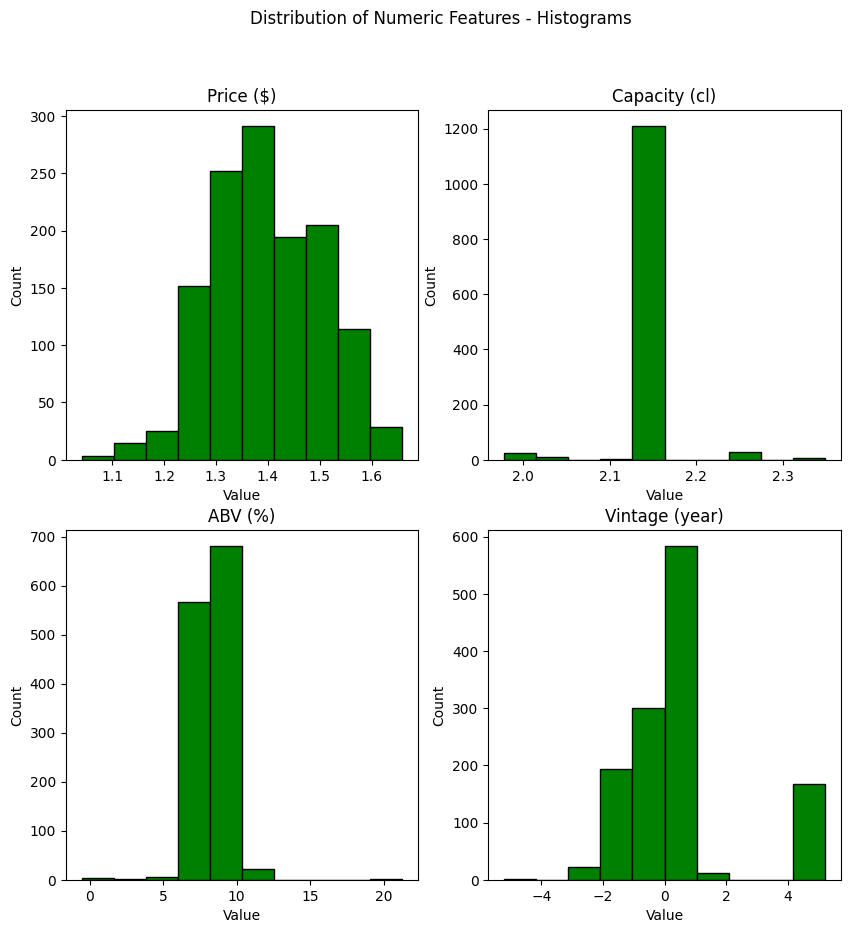

In [24]:
# re-plot to check for normal distributions
fig, axes = plt.subplots(2, 2, figsize = (10, 10)) # 4 plots for 4 numeric features
axes = axes.flatten()

for i, col in enumerate(df_num.columns):   # make histograms for numeric features
    axes[i].hist(df_num[col], bins = 10, color = 'green', edgecolor = 'black')
    axes[i].set_title(f"{col} {units.get(col, 'units')}")
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel('Value')

fig.suptitle('Distribution of Numeric Features - Histograms')

The numeric features are much more normally distributed now, which will make it easier to perform various unsupervised learning methods on them later.
_____
###  Data Cleaning - Non-Numeric Features
Now to deal with the non-numeric features. There are a few different types of these. Some of them can be treated as categorical, because there are few entries for these categories, like `Closure` and `Type`, which have 4 or 6 unique values. These can be encoded into new categories using one-hot encoding.

`Country` and `Style` are tricky categories that could be handled multiple ways. They have 16 or 25 unique values. These could be handled with frequency encoding or one-hot encoding. Clustering methods like K-Means and DBSCAN work better for treating features as categorical, but creating new categories will also increase data dimensionality. For now, these will be treated with one-hot encoding as well, but this method can later be adjusted if it results in poor model performance.

Then there's the categories `Grape` and `Region`, with a relatively large number of unique values (112 and 94). These are probably too varied to be treated with one-hot encoding, as this would add far too many new features and increase dimensionality greatly. These are probably best treated with frequency encoding, where the category values are replaced with the frequency counts of that value. This allows to keep track of how often an entry shows up, while not increasing dimensionality.

The remaining features have far too much variety to be treated as individual categories, like `Title` (1279 unique values), `Description` (1274 unique values), and `Characteristics` (888 unique values). These can be handled with word embedding methods like vectorization, since most of the entries only show up once, making frequency encoding a poor representation of this useful data.

In [25]:
df_non_num = df.drop(columns = df_num.columns) # make a dataframe of all the non-numerical features
print(df[df_non_num.columns].nunique()) # print out unique number of values in each

Title              1279
Description        1274
Grape               112
Closure               4
Country              25
Characteristics     888
Type                  6
Region               94
Style                16
dtype: int64


____
### One-Hot Encoding
In order to handle `Closure`, `Country`, `Type`, and `Style`, which have the lowest number of unique values of all the non-numeric features, they can be encoded into categories. Since none of these features have any meaningful order, they should not be treated as ordered categories. Instead, they can be handled with **one-hot encoding**, where each unique category within the feature is turned into a binary column. We can also use pie charts to get a look at the distribution of these features.

Text(0.5, 0.98, 'Distribution of Categorical Features')

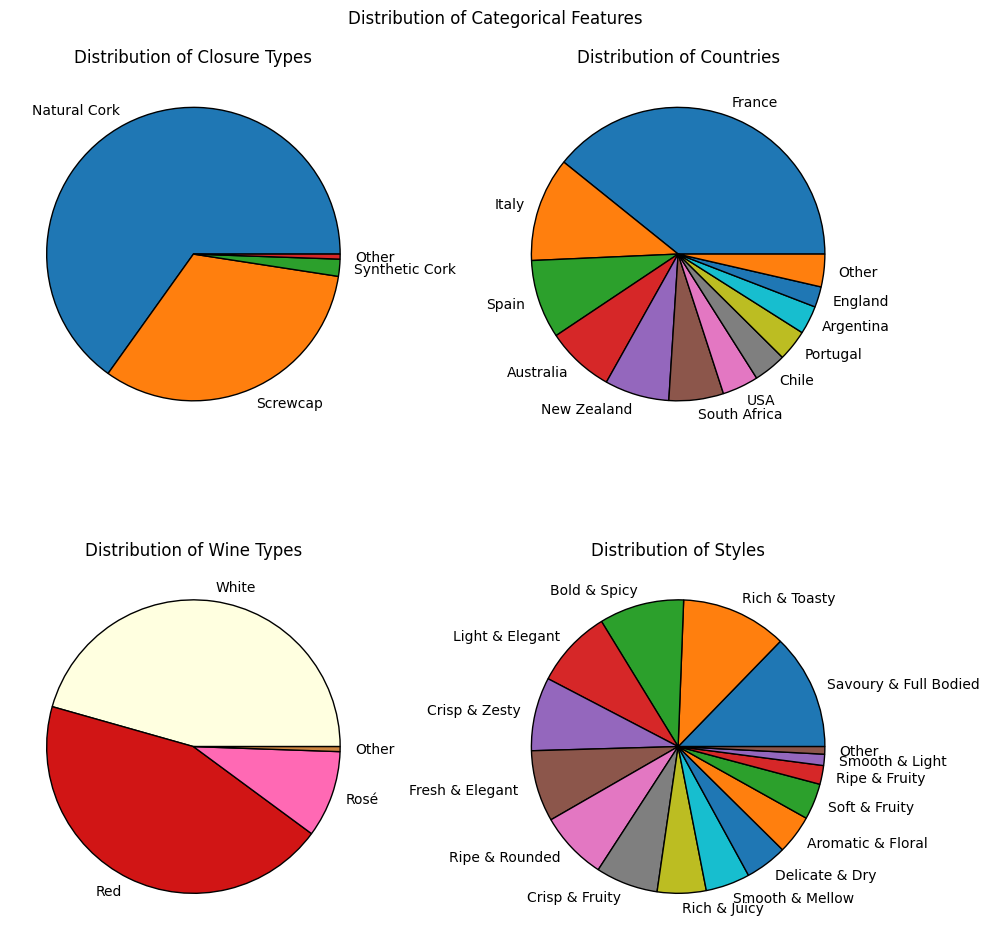

In [26]:
fig, axes = plt.subplots(2,2, figsize = (10, 10)) # create subplot for the 2 plots

def group_others(types, threshold = 0.01): # helper function to group together categories with < 1% for label visibility
    percentages = types / types.sum()
    other = percentages[percentages < threshold].index
    if len(other) > 0:
        types['Other'] = types[other].sum()
    types = types.drop(other)
    return types
    
##########################################################################################################################################
# Closure
closure_types = df['Closure'].value_counts() # gather list of closure categories for the legend
closure_types = group_others(closure_types) # use helper function to group small categories

# closure types pie chart
closure_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = closure_types.index, ax = axes[0, 0])
axes[0, 0].set_ylabel('')
axes[0, 0].set_title('Distribution of Closure Types')

##########################################################################################################################################

# Country
country_types = df['Country'].value_counts() # gather list of countries for the legend
country_types = group_others(country_types) # use helper function to group small categories

# countries pie chart
country_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = country_types.index, ax = axes[0, 1])
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('Distribution of Countries')

##########################################################################################################################################
# Type

# list of wine colors to coordinate on plot
wine_colors = ['#FFFFE0',  # White
               '#D11515',  # Red
               '#FF69B4',  # Rosé
               '#CD853F',  # Tawny
               '#FFA500',  # Orange
               '#8B4513']  # Brown

wine_types = df['Type'].value_counts() # gather list of wine types for the legend
wine_types = group_others(wine_types) # use helper function to group small categories

# wine types pie chart
wine_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = wine_types.index, 
                               colors = wine_colors, ax = axes[1, 0])
axes[1, 0].set_ylabel('')
axes[1, 0].set_title('Distribution of Wine Types')

##########################################################################################################################################
# Style

style_types = df['Style'].value_counts() # gather list of styles for the legend
style_types = group_others(style_types) # use helper function to group small categories

style_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = style_types.index, ax = axes[1, 1])
axes[1, 1].set_ylabel('')
axes[1, 1].set_title('Distribution of Styles')


##########################################################################################################################################
plt.tight_layout()
fig.suptitle('Distribution of Categorical Features')

In [27]:
df_encoded = df_transformed.copy() # make a new dataframe for the encoded data

# encode categories (drop_first param drops one category to avoid redundancy/multicollinearity)
df_encoded = pd.get_dummies(df_transformed, columns = ['Closure', 'Country', 'Type', 'Style'], drop_first = True)

df_encoded = df_encoded.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x) # convert the true/false values to booleans

______
### Frequency Encoding
In order to handle the features with many unique values, but not enough to justify text embedding, frequency encoding can be implemented. This transforms the category values into their frequency count. This allows for easy handling of the features, while also retaining the frequency of the value, which is valuable to clustering.

In [28]:
# encode the categories with their frequency count
df_encoded['Grape_Freq'] = df_transformed.groupby('Grape')['Grape'].transform('count') / len(df_transformed)
df_encoded['Region_Freq'] = df_transformed.groupby('Region')['Region'].transform('count') / len(df_transformed)

# drop the original features
df_encoded = df_encoded.drop(['Grape', 'Region'], axis = 1)

# fill missing values with the mean for that column
df_encoded['Grape_Freq'] = df_encoded['Grape_Freq'].fillna(df_encoded['Grape_Freq'].mean())
df_encoded['Region_Freq'] = df_encoded['Region_Freq'].fillna(df_encoded['Region_Freq'].mean())

Text(0.5, 0.98, 'Distribution of Frequency Features - Histograms')

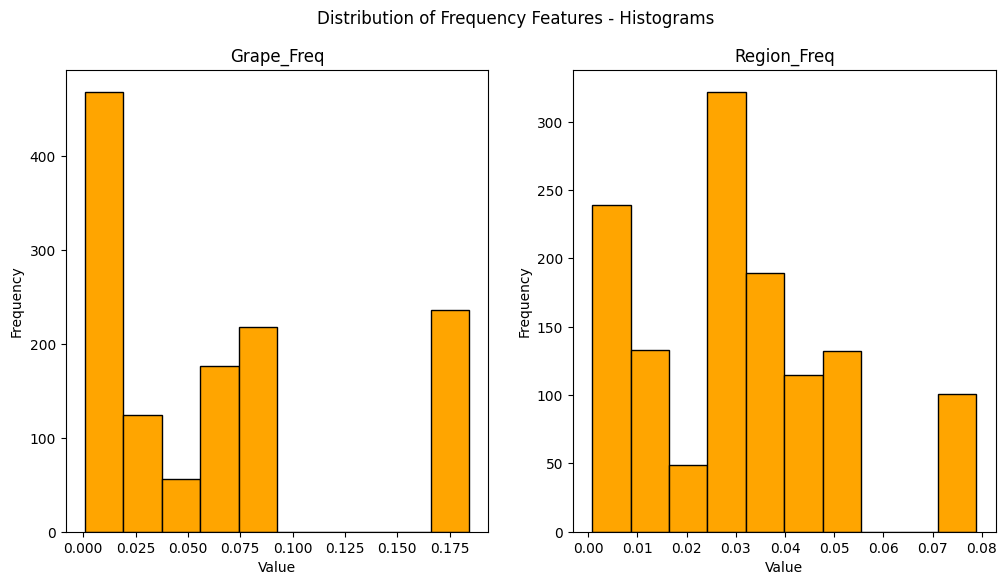

In [29]:
df_freq = df_encoded[['Grape_Freq', 'Region_Freq']] # make a df of frequency count features for plotting

fig, axes = plt.subplots(1, 2, figsize = (12, 6)) # 2 plots for 2 features
#axes = axes.flatten()

for i, col in enumerate(df_freq.columns):   # make histograms for frequency count features
    axes[i].hist(df_freq[col], bins = 10, color = 'orange', edgecolor = 'black')
    axes[i].set_title(f"{col}")
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('Value')

fig.suptitle('Distribution of Frequency Features - Histograms')

Even though the frequency counts of these features are not normally distributed, they do not need to be transformed like the numerical features were. Clustering methods do not require frequency data to be normally distributed.
_____
### Text Embedding
Last but not least, `Title` (1279 unique values), `Description` (1274 unique values), and `Characteristics` (888 unique values) need to be converted to numerical vectors so that they can be processed with unsupervised machine learning methods.

#### Text Preprocessing
Before any conversion to numerical vectors, the data needs to be preprocessed a bit. It is generally good practice to make all words lower case, remove any special characters, and tokenize the text (split the text into 'terms'). The text columns can also be combined into one column. This is beneficial for multiple reasons. First, this gives a more holistic and overall description of the wine. Secondly, if any of the columns have a `None` value in them, combining the other 2 columns for that row will give insight into that wine, without having to lose the whole row just because of one incomplete value.

In [30]:
# combine all text columns into one column
df_encoded.loc[:, 'Combined_Text'] = df_encoded['Title'] + " " + df_encoded['Description'] + " " + df_encoded['Characteristics']
df_encoded = df_encoded.drop(['Title', 'Description', 'Characteristics'], axis = 1) # drop original columns 
df_text = pd.DataFrame() # create new data frame for only text features
df_text = df_encoded['Combined_Text'] # fill new data frame with combined text

In [31]:
df_text = df_text.fillna('').astype(str) # if any entries have None for all text features, fill it with empty space to avoid errors
df_text = df_text.str.replace(r'[^\w\s]', '', regex = True) # remove special characters
df_text = df_text.str.replace(r'\d+', '', regex = True) # remove numbers (most of these are year which is already captured in `Vintage`)
df_text = df_text.str.lower() # convert text to all lowercase
df_text['Tokenized'] = df_text.apply(word_tokenize) # convert strings to 'tokens'

#### Word Vectorization - Word2Vec
TF-IDF is a common method for converting text data to numeric vectors because it considers a terms frequency in the specified text, as well as its frequency in all text. It is also a fast method for processing a lot of text data. **Word2Vec** is a similar method but might be better suited for this data, because it capters relationships between words (i.e. vanilla and coconut are similar words and this method would take that into consideration). There also isn't an enormous amount of text data in this dataset, so there's no need for the fastest method. 

In [32]:
w2v = Word2Vec(sentences = df_text['Tokenized']) # train Word2Vec model on our text data
word_vecs = w2v.wv # save into variable
word_vecs.most_similar('vanilla') # show words similar to vanilla or words that show up with the word vanilla often

[('violet', 0.9961503744125366),
 ('raspberry', 0.9932599067687988),
 ('pepper', 0.9926689863204956),
 ('strawberry', 0.9912276268005371),
 ('cassis', 0.9900894165039062),
 ('dried', 0.989860475063324),
 ('sweet', 0.9889266490936279),
 ('herbs', 0.988819420337677),
 ('red', 0.9882079362869263),
 ('cranberry', 0.9877747297286987)]

Looking at the reults for words similar to vanilla, many fruit/herbal aromas appear. This makes sense as vanilla is often paired with words like cherry, fruits, strawberry.

Next, the average word embedding values for each row can be calculated, and we can put this value back into our original dataframe for unsupervised learning methods.

In [33]:
df_text['Word_Vecs'] = df_text['Tokenized'].apply( # get avg word embedding
    lambda tokenized_text: np.mean([w2v.wv[word] for word in tokenized_text if word in w2v.wv], axis = 0)
    if any(word in w2v.wv for word in tokenized_text) else np.zeros(w2v.vector_size) # if token not in vocab, fill with zeros
)
word_vecs_df = pd.DataFrame(df_text['Word_Vecs'].to_list()) # convert Word_Vecs into separate columns
word_vecs_df.columns = [f'word_vec_{i+1}' for i in range(word_vecs_df.shape[1])] # rename columns word_vec_1, word_vec_2,...
df_encoded = pd.concat([df_encoded, word_vecs_df], axis = 1) # combine word_vec columns with original df

df_encoded = df_encoded.drop(['Combined_Text'], axis = 1) # drop combined text since it's represented with the vectors
df_encoded = df_encoded.dropna() # drop any remainining null values
df_wine = df.loc[df_encoded.index] # keep same rows in original df as df_encoded, for looking at model results later
df_wine.reset_index(drop=True, inplace=True) # reset indexing so everything matches 
df_encoded.reset_index(drop=True, inplace=True)
df_encoded.head()

,Price,Capacity,ABV,Vintage,Closure_Screwcap,Closure_Synthetic Cork,Closure_Vinolok,Country_Australia,Country_Austria,Country_Bulgaria,...,word_vec_91,word_vec_92,word_vec_93,word_vec_94,word_vec_95,word_vec_96,word_vec_97,word_vec_98,word_vec_99,word_vec_100
0,1.263952,2.134882,8.693540,5.199338,0.0,0.0,0.0,0.0,0.0,0.0,...,0.382569,0.180102,-0.031318,-0.056586,0.502915,0.293111,0.283239,-0.320942,0.360527,-0.131312
1,1.370766,2.134882,8.415910,0.018820,0.0,0.0,0.0,0.0,0.0,0.0,...,0.428064,0.184189,0.054093,-0.062012,0.453523,0.340231,0.118575,-0.182361,0.311922,-0.128580
2,1.318341,2.134882,8.135962,0.628724,1.0,0.0,0.0,0.0,0.0,0.0,...,0.444661,0.155341,-0.061330,0.018396,0.579407,0.306990,0.270626,-0.319453,0.340024,-0.085665
3,1.393227,2.134882,8.415910,0.628724,0.0,0.0,0.0,0.0,0.0,0.0,...,0.358268,0.152632,-0.038631,-0.046450,0.466492,0.225966,0.272392,-0.291828,0.329654,-0.089976
4,1.370766,2.134882,8.415910,0.018820,0.0,0.0,0.0,0.0,0.0,0.0,...,0.404000,0.190198,0.006646,-0.048240,0.497204,0.343974,0.223273,-0.258460,0.357774,-0.128244


In [34]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Columns: 153 entries, Price to word_vec_100
dtypes: float64(153)
memory usage: 1.5 MB


Now that all the features are convered to numerical data, unsupervised learning methods can be applied to this data. There are now 153 columns, so we can first perform dimensionality reduction to focus on the most important ones.
_____
## Unsupervised Learning Methods

### Principal Component Analysis (PCA)
Since there are now 153 features in the dataframe, it's best to perform some **principal component analysis** in order to reduce dimensionality. This can be done with sklearn's PCA class. This works by projecting the data to a lower dimensional space, which it does by identifying the principal components in which the data varies the most and projecting the data on these new directions. Choosing an optimal `n_components` parameter is crucial to performing PCA well. Finding the point of optimal explained variance before adding components results in diminishing returns is a good way to choose `n_components`. A visual way to decide this is by looking at the **elbow plot** that plots number of components vs. cumulative variance explained, and choosing the 'elbow'.

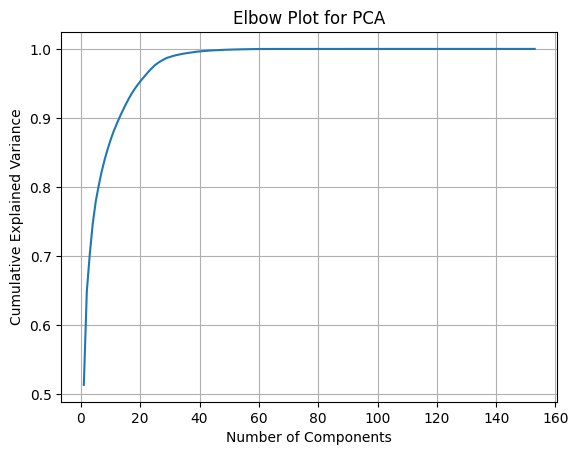

In [35]:
pca = PCA() # initialize pca
reduced_data = pca.fit_transform(df_encoded) # train on df_encoded
explained_var = pca.explained_variance_ratio_ # calculate explained variance

plt.figure()  # plot cumulative explained variance for all possible n_components
plt.plot(range(1, len(explained_var) + 1), explained_var.cumsum()) 
plt.title('Elbow Plot for PCA')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Choosing `n_components` to be 20 results in a cumulative explained variance of about 95%, while not increasing dimensionality by too much. This is about the point where adding components only has less significant increases in explained variance.

In [36]:
pca = PCA(n_components = 20)
pca_data = pca.fit_transform(df_encoded)

explained_var = pca.explained_variance_ratio_
explained_var.cumsum()

array([0.51374323, 0.64832173, 0.70269707, 0.74683755, 0.77884542,
       0.80179143, 0.82212175, 0.83954774, 0.85436393, 0.86806555,
       0.88010304, 0.8905483 , 0.90050116, 0.90977235, 0.91854776,
       0.92678638, 0.93447925, 0.94115707, 0.9471888 , 0.952915  ])

_________
## Clustering
### Clustering Method Breakdown

Now that the number of dimensions has been optimally reduced, several different clustering methods can be performed on the newly transformed data. Each come with advantages and disadvantages. Below is a table summarizing the methods used in this project along with some pros and cons for each.

| **Clustering Algorithm**    | **Advantages**                                               | **Disadvantages**                                               |
|------------------------|----------------------------------------|------------------------------------------------|
| **K-Means Clustering**  | - Simple and fast     | - Assumes clusters of similar size and density       |
|             | - Easy to implement and interpret      | - Sensitive to initial centroids      |
|       | - Works well for large, well-separated clusters      | - Requires the number of clusters to be specified beforehand   |
| **Agglomerative (Hierarchical) Clustering**| - No need to predefine the number of clusters| - Computationally expensive (O(n^3) in worst case)   |
|                             | - Provides a dendrogram to visualize cluster relationships  | - Can be sensitive to noisy data                               |
|                             | - Can capture arbitrarily shaped clusters  | - Merges clusters without a guarantee of the best result      |
| **DBSCAN (Density-Based Spatial Clustering)** |  - Can capture arbitrarily shaped clusters  | - Struggles with clusters of varying densities                 
|   | - Does not require number of clusters to be pre-defined | - Sensitive to choice of `eps` (distance parameter)    |
|             | - Can identify outliers/noise as a separate class | - Performs poorly with high-dimensional data    |

Looking at these three methods, DBSCAN seems like it may not be the best fit, as it performs poorly with high-dimensional data, but if `eps` can be optimized, it might give more accurate clusters. Hierarchical clustering seems like a good option because it can capture arbitrarily shaped clusters, but it is sensitive to noise. This may be an issue with this small dataset and the outliers seen in the numeric features. K-means clustering is a simple method that may work well, but it might not be optimal if our clusters aren't similar sizes/densities. It's best to try to optimize all three of these models, and then choose the best one of all.

### Performance Metrics
In order to optimize each of these models, and choose between the top models, there are several metrics for assessing performance. These can be used to decide how many clusters to use, as well as several other **hyperparameters** that can be modified to improve performance. Some common metrics for assessing clustering performance include **Silhouette Score**, **Davies-Bouldin index (DBI)**, and **Calinski-Harabasz Index/Variance Ratio Criterion**.

**Silhouette Score**
- measures how similar an object is to its cluster, relative to other clusters
- ranges -1 to 1, where score closer to 1 indicates clusters are compact and separated

**Davies-Bouldin Index (DBI)**
- measures average similarity ratio of each cluster relative to the cluster closest to it
- lower score indicates distinct clusters

**Calinski-Harabasz Index/Variance Ratio Criterion**
- measures ratio of the sum of between-cluster dispersion and within-cluster dispersion
- higher score indicates distince, dense clusters

_____
### K-Means Clustering
The first method we'll use is k-means clustering. K-means clustering works by assigning labels to data points based on their distance to centroids. A crucial parameter in K-Means is k, the number of clusters. An elbow plot can also be modeled for this to compare the number of clusters to the Within-Cluster Sum of Squares (WCSS) and choose the "elbow" point of diminishing returns.

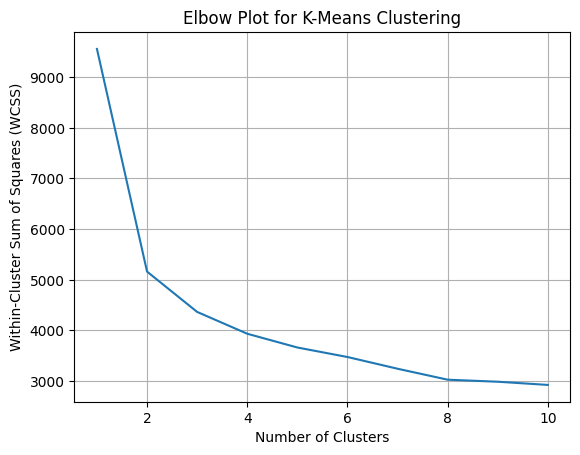

In [37]:
wcss = []
for i in range(1,11): # create kmeans with clusters from 1 to 10 and add WCSS for each 
    kmeans = KMeans(n_clusters = i, random_state = 123)
    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)


plt.figure() # plot the k vs WCSS
plt.plot(range(1,11), wcss)
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

Based on the elbow plot above, the optimal number of clusters is **2**, as this is the point of diminishing returns for additional clusters - additional clusters only improve the Within-Cluster Sum of Squares (WCSS) slightly.

In [38]:
kmeans = KMeans(n_clusters = 2, random_state = 123) # create model with 2 clusters
labels = kmeans.fit_predict(pca_data) # create labels from this model

### t-SNE for Visualization
In order to visualize the predicted clusters, another unsupervised learning method can be used. t-SNE (t-distributed Stochastic Neighbor Embedding) is a good method for further reducing dimensionality. Though we don't want to reduce our dimensions further for clustering, it can be useful to do so for visualization purposes. By projecting our data onto 2 dimensions, we can then visualize the clusters that were created by k-means.

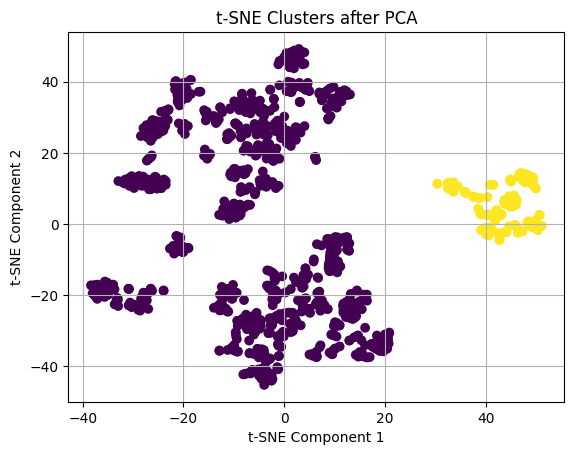

In [39]:
tsne = TSNE(n_components = 2, random_state = 123) # initialize t-SNE with 2 dimensions
tsne_data = tsne.fit_transform(pca_data) # fit to our pca_data

plt.figure()
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = labels) # color code with labels from K-Means clusters
plt.title('t-SNE Clusters after PCA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

The plot above shows two different clusters, which seem to be far apart and clearly defined. The yellow cluster is dense and separated from the rest of the data points. However, the purple cluster is more spread out, and looks like it could even be split further into two more clusters. Let's go ahead and try visualiing a model with three clusters.

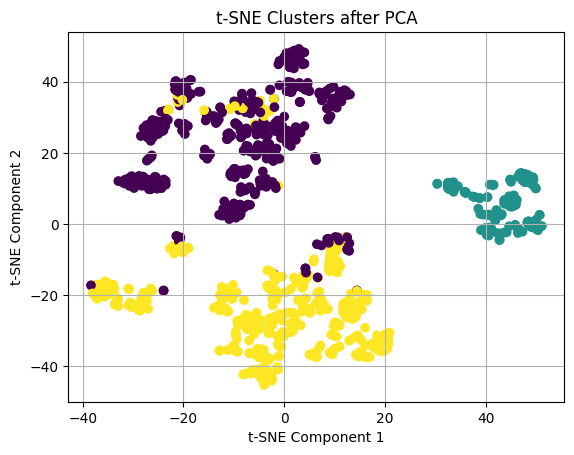

In [40]:
kmeans_3 = KMeans(n_clusters = 3, random_state = 123) # fit model with 3 clusters
labels_3 = kmeans_3.fit_predict(pca_data) # create labels

plt.figure() # plot same 2 component tsne, but with the 3 cluster labels
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c = labels_3)
plt.title('t-SNE Clusters after PCA')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.show()

This looks better, but there are a few points marked yellow that look like they are part of the purple cluster, and a few points marked purple that appear to be in the yellow cluster. Since t-SNE is mostly used for visualization, and we are only viewing the data in a 2D space when we actually have 20 principal components, it's best to use numerical metrics to compare the models and optimize the hyperparameters.

#### Hyperparameter Optimization
We can choose a few different values for each of the k-means hyperparameters and then loop through all the possible combinations, and take a look at the three metrics stated earlier to choose our optimized model.

In [41]:
# set hyperparameter values to loop through
n_clusters = [2, 3, 4] # number of clusters
init = ['k-means++', 'random'] # centroid initialization method
n_init = ['auto', 10, 20] # number of times algorithm will run with different centroid seeds
max_iter = [300, 500] # max number of iterations algorithm will run for each initialization
tol = [1e-4, 1e-5] # convergence tolerance
algorithm = ['auto', 'full', 'elkan'] # algorithm used

results = [] 
 
for n_cluster, init_method, n_init, max_iter in product(n_clusters, init, n_init, max_iter): # loop through all combinations
    kmeans = KMeans(n_clusters = n_cluster, init = init_method, n_init = n_init, max_iter = max_iter, random_state = 123)
    kmeans.fit(pca_data) # fit k-means model 
    labels = kmeans.fit_predict(pca_data) # create labels

    # calculate performance metrics
    silhouette = silhouette_score(pca_data, labels)
    dbi = davies_bouldin_score(pca_data, labels)
    ch = calinski_harabasz_score(pca_data, labels)

    # add performance metrics to results
    results.append({
        'n_clusters': n_cluster,
        'init': init_method,
        'n_init': n_init,
        'max_iter': max_iter,
        'silhouette_score': silhouette,
        'davies_bouldin_score': dbi,
        'calinski_harabasz_score': ch
    })

results_kmeans = pd.DataFrame(results) # store results in df

#### Best Silhouette Score

In [42]:
results_kmeans.loc[results_kmeans['silhouette_score'].idxmax()]

n_clusters                           2
init                         k-means++
n_init                            auto
max_iter                           300
silhouette_score              0.572392
davies_bouldin_score           0.68099
calinski_harabasz_score    1079.738719
Name: 0, dtype: object

#### Best Davies-Bouldin Score

In [43]:
results_kmeans.loc[results_kmeans['davies_bouldin_score'].idxmin()]

n_clusters                           2
init                         k-means++
n_init                            auto
max_iter                           300
silhouette_score              0.572392
davies_bouldin_score           0.68099
calinski_harabasz_score    1079.738719
Name: 0, dtype: object

#### Best Calinski-Harabsz Score

In [44]:
results_kmeans.loc[results_kmeans['calinski_harabasz_score'].idxmax()]

n_clusters                           2
init                         k-means++
n_init                            auto
max_iter                           300
silhouette_score              0.572392
davies_bouldin_score           0.68099
calinski_harabasz_score    1079.738719
Name: 0, dtype: object

In [45]:
best_kmeans = KMeans(n_clusters = 2, init = 'k-means++', n_init = 'auto', max_iter = 300, random_state = 123)
best_kmeans.fit(pca_data)
kmeans_labels = best_kmeans.fit_predict(pca_data)

# calculate performance metrics
silhouette = silhouette_score(pca_data, kmeans_labels)
dbi = davies_bouldin_score(pca_data, kmeans_labels)
ch = calinski_harabasz_score(pca_data, kmeans_labels)
intermodel_results = []

# add top K-Means model to results
intermodel_results.append({
    'model': 'K-Means',
    'silhouette_score': silhouette,
    'davies_bouldin_score': dbi,
    'calinski_harabasz_score': ch
})

As it turns out, the models with n_clusters set to 2 did better than all the rest. This, along with k-means++ as the initialization method, auto for n_init, and 300 max iterations seems to be our best k-means model.

___ 
### Hierarchical Clustering
Another model we can try out is hierarchical clustering. This works by building trees of clusters by either merging small clusters, or splitting large clusters. We'll be using **agglomerative clustering** which is hierarchical clustering from a bottom-up approach, where it starts with each point as its own cluster, and progressively merges them into bigger clusters. One useful visualization for this method is the dendogram, which shows the hierarchy of clusters created for a specific method.

#### Dendogram for Agglomerative Clustering

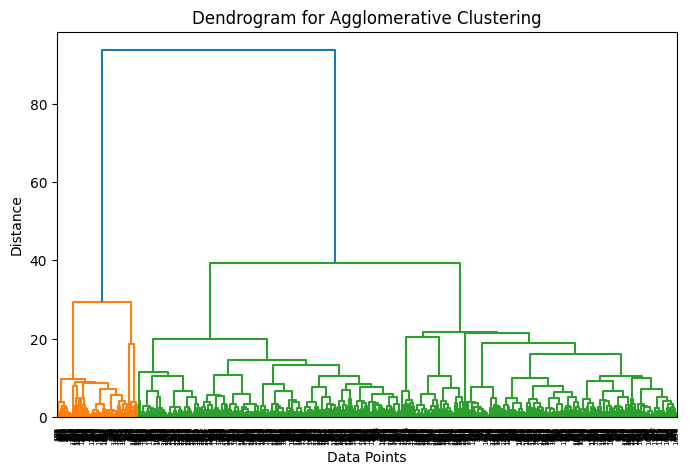

In [46]:
Z = linkage(pca_data, method = 'ward')

plt.figure(figsize=(8, 5))
dendrogram(Z)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

Looking at the dendogram for this model, it looks like the clusters become clear and well defined around 2 or 3 clusters.. The initial clustering is noisy and creates many different groups, but it quickly gets reduced to 3 pretty clear clusters. 4 clusters may also be a good choice, but anything more than that will no result in very well seperated clusters.
#### Hyperparameter Optimization

In [47]:
n_clusters = [2, 3, 4] # number of clusters
affinity = ['euclidean', 'manhattan', 'cosine'] # metric used to calculate distance between clusters
links = ['single', 'complete', 'average', 'ward'] # method used to compute distance between clusters during merging process

results = []

for n_cluster, aff, link in product(n_clusters, affinity, links): # loop through all combinations
    if link == 'ward': # ward only works with euclidean
        agg_clustering = AgglomerativeClustering(n_clusters = n_cluster, linkage = link)
    else:
        agg_clustering = AgglomerativeClustering(n_clusters = n_cluster, metric = aff, linkage = link)
    labels = agg_clustering.fit_predict(pca_data)

    # calculate performance metrics
    silhouette = silhouette_score(pca_data, labels)
    dbi = davies_bouldin_score(pca_data, labels)
    ch = calinski_harabasz_score(pca_data, labels)

    # add performance metrics to results
    results.append({
        'n_clusters': n_cluster,
        'affinity': aff if link != 'ward' else 'euclidean',
        'linkage': link,
        'silhouette_score': silhouette,
        'davies_bouldin_score': dbi,
        'calinski_harabasz_score': ch
    })

results_hier = pd.DataFrame(results) # store results in df

#### Best Silhouette Score

In [48]:
results_hier.loc[results_hier['silhouette_score'].idxmax()]

n_clusters                         2
affinity                   euclidean
linkage                       single
silhouette_score            0.756431
davies_bouldin_score        0.281698
calinski_harabasz_score    52.715431
Name: 0, dtype: object

#### Best Davies-Bouldin Score

In [49]:
results_hier.loc[results_hier['davies_bouldin_score'].idxmin()]

n_clusters                         2
affinity                   euclidean
linkage                       single
silhouette_score            0.756431
davies_bouldin_score        0.281698
calinski_harabasz_score    52.715431
Name: 0, dtype: object

#### Best Calinski Harabasz Score

In [50]:
results_hier.loc[results_hier['calinski_harabasz_score'].idxmax()]

n_clusters                           2
affinity                     euclidean
linkage                           ward
silhouette_score              0.572392
davies_bouldin_score           0.68099
calinski_harabasz_score    1079.738719
Name: 3, dtype: object

In [51]:
best_hier = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
hier_labels = best_hier.fit_predict(pca_data)

# calculate performance metrics
silhouette = silhouette_score(pca_data, hier_labels)
dbi = davies_bouldin_score(pca_data, hier_labels)
ch = calinski_harabasz_score(pca_data, hier_labels)

# add top hierarchical clustering model to results
intermodel_results.append({
    'model': 'Hierarchical',
    'silhouette_score': silhouette,
    'davies_bouldin_score': dbi,
    'calinski_harabasz_score': ch
})

The best model for hierarchical clustering is a bit less straight forward. The same parameters got the best Silhouette and DBI, but a different set of parameters got the best Calinski-Harabasz Index. However, the model with the higher Calinski-Harabasz order did not have much worse scores in the other two categories, while the model that did best in those did have a much lower Calinski-Harabasz score. Therefore, I chose the model with Euclidean affinity and ward linkage.

______
### Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
A final clustering method to try on this wine data is DBSCAN. This method actually doesn't require a prespecified number of clusters like the previous two methods, but automatically detects clusters of varying shapes on its own. It does so by clustering together dense points, and marking sparser points as noise.

In [52]:
eps_values = [0.3, 0.5, 0.7]  # eps (maximum distance between two samples)
min_samples_values = [3, 5, 10]  # minimum number of points to form a dense region

results = []

for eps, min_samples in product(eps_values, min_samples_values):  # iterate through all possible combinations
    dbscan = DBSCAN(eps = eps, min_samples = min_samples)
    dbscan_labels = dbscan.fit_predict(pca_data) 


    if len(set(dbscan_labels)) > 1:  # only calculate metrics if there are at least 2 clusters
        silhouette = silhouette_score(pca_data, dbscan_labels)
        dbi = davies_bouldin_score(pca_data, dbscan_labels)
        ch = calinski_harabasz_score(pca_data, dbscan_labels)
        
        # add performance metrics to results
        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'silhouette_score': silhouette,
            'davies_bouldin_score': dbi,
            'calinski_harabasz_score': ch
        })

results_dbscan = pd.DataFrame(results) # store results in df

#### Best Silhouette Score

In [53]:
results_dbscan.loc[results_dbscan['silhouette_score'].idxmax()]

eps                         0.700000
min_samples                 3.000000
silhouette_score           -0.000281
davies_bouldin_score        1.641027
calinski_harabasz_score    19.538122
Name: 6, dtype: float64

#### Best Davies-Bouldin Score

In [54]:
results_dbscan.loc[results_dbscan['davies_bouldin_score'].idxmin()]

eps                         0.300000
min_samples                 3.000000
silhouette_score           -0.402314
davies_bouldin_score        1.112935
calinski_harabasz_score    12.063641
Name: 0, dtype: float64

#### Best Calinski Harabasz Score

In [55]:
results_dbscan.loc[results_dbscan['calinski_harabasz_score'].idxmax()]

eps                         0.700000
min_samples                10.000000
silhouette_score           -0.118587
davies_bouldin_score        1.464348
calinski_harabasz_score    41.094179
Name: 8, dtype: float64

In [56]:
best_dbscan = dbscan = DBSCAN(eps = 0.7, min_samples = 3)
dbscan_labels = best_dbscan.fit_predict(pca_data)

# calculate performance metrics
silhouette = silhouette_score(pca_data, dbscan_labels)
dbi = davies_bouldin_score(pca_data, dbscan_labels)
ch = calinski_harabasz_score(pca_data, dbscan_labels)

# add top hierarchical clustering model to results
intermodel_results.append({
    'model': 'DBSCAN',
    'silhouette_score': silhouette,
    'davies_bouldin_score': dbi,
    'calinski_harabasz_score': ch
})

The best choice for DBSCAN is also not straightforward, as different combinations result in the best score for each metric. However, the models with the highest DBI and Calinski-Harabasz Index, both have pretty low and negative Silhouette scores, indicating poor cluster separation. The best choice is then an `eps` of 0.7 and `min_samples` of 3. Even though this model also has a negative Silhouette score, it is very close to 0, and much better than the other models. It also doesn't sacrifice the other scores as much.
_____
### Model Selection - K-Means / Hierarchical Clustering
Now that we've optimized within each model, we can look at the scores of all the top models and choose the best one of all.

In [57]:
top_models = pd.DataFrame(intermodel_results)
top_models

,model,silhouette_score,davies_bouldin_score,calinski_harabasz_score
0,K-Means,0.572392,0.680990,1079.738719
1,Hierarchical,0.572392,0.680990,1079.738719
2,DBSCAN,-0.000281,1.641027,19.538122


As it turns out, the optimal k-means model and hierarchical model both created the same clusters, as they performed the same for all three scores. These models also outperformed DBSCAN in all 3 metrics. Therefore, the choice of model/labels is arbitrary between the top 2. I've chosen the labels from hierarchical clustering as the final labels to be able to visualize the results.
______
## Visualizing Results

We can add the labels from this model to our original data frame to visualize which features had the most impact on the clusters.

In [58]:
# best hierarchical model 
df_wine['clusters'] = hier_labels # add a column for hierarchical clusters in original df (with original wine names, descriptions, etc.)
df_wine['clusters'] = df_wine['clusters'] + 1 # change cluster names from 0 and 1 to 1 and 2 for presentation purposes

Text(0.5, 0.98, 'Distribution of Numeric Features Across Clusters - Boxplots')

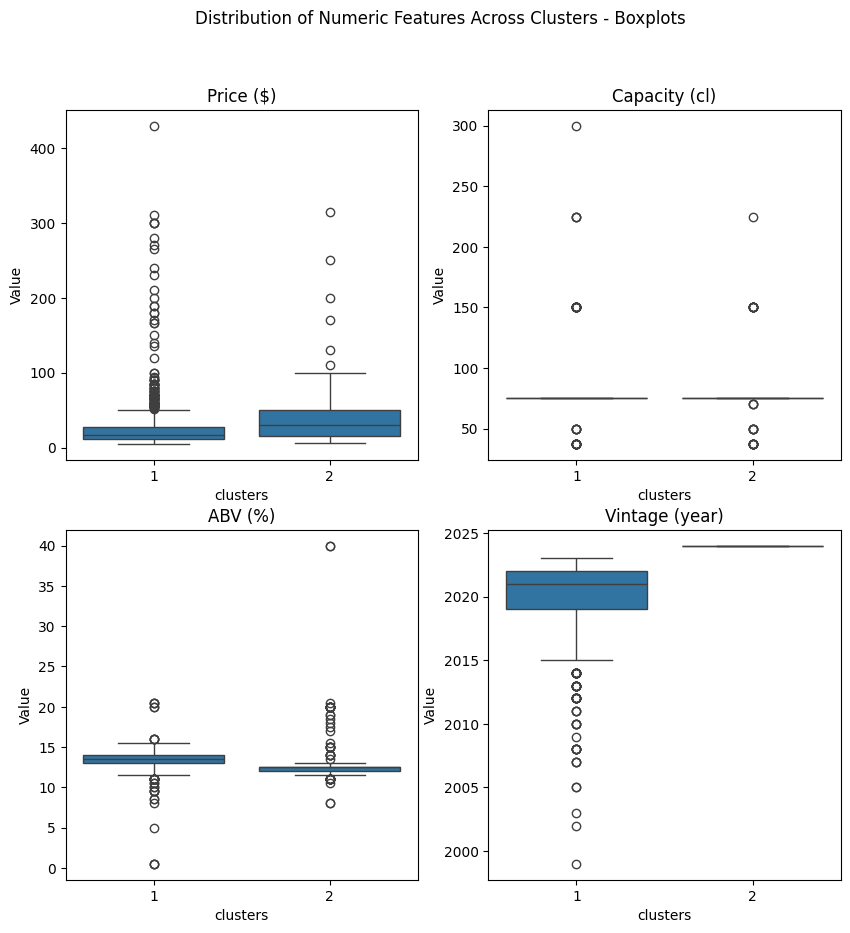

In [59]:
units = {       # make a dictionary of units to put in the title of the plots
    'Price': '($)',
    'Capacity': '(cl)',
    'ABV': '(%)',
    'Vintage': '(year)'
}

fig, axes = plt.subplots(2, 2, figsize = (10, 10)) # 4 plots for 4 numeric features
axes = axes.flatten()
for i, col in enumerate(df_num.columns):
    sns.boxplot(x = 'clusters', y=col, data=df_wine, ax=axes[i])
    axes[i].set_title(f"{col} {units.get(col, 'units')}")
    axes[i].set_ylabel('Value')
    
fig.suptitle('Distribution of Numeric Features Across Clusters - Boxplots')

Looking at the boxplots above, it appears that `Capacity` was not a factor in the clustering, as there is an even spread of these across the two clusters. Cluster 2 looks like it might have a slightly higher `Price` range, and a slightly lower `ABV` range, but not by a considerable amount. `Vintage` was definitely a big factor in the clustering methods, as it appears that all the wines made in 2024 were placed in cluster 2, and all the other wines in cluster 1. The clusters are also uneven, with 1103 wines in cluster 1 and only 167 wines in cluster 2.

In [60]:
cluster_1 = df_wine[df_wine['clusters'] == 1]
cluster_2 = df_wine[df_wine['clusters'] == 2]
cluster_counts = df_wine['clusters'].value_counts()

print(cluster_counts)

clusters
1    1103
2     167
Name: count, dtype: int64


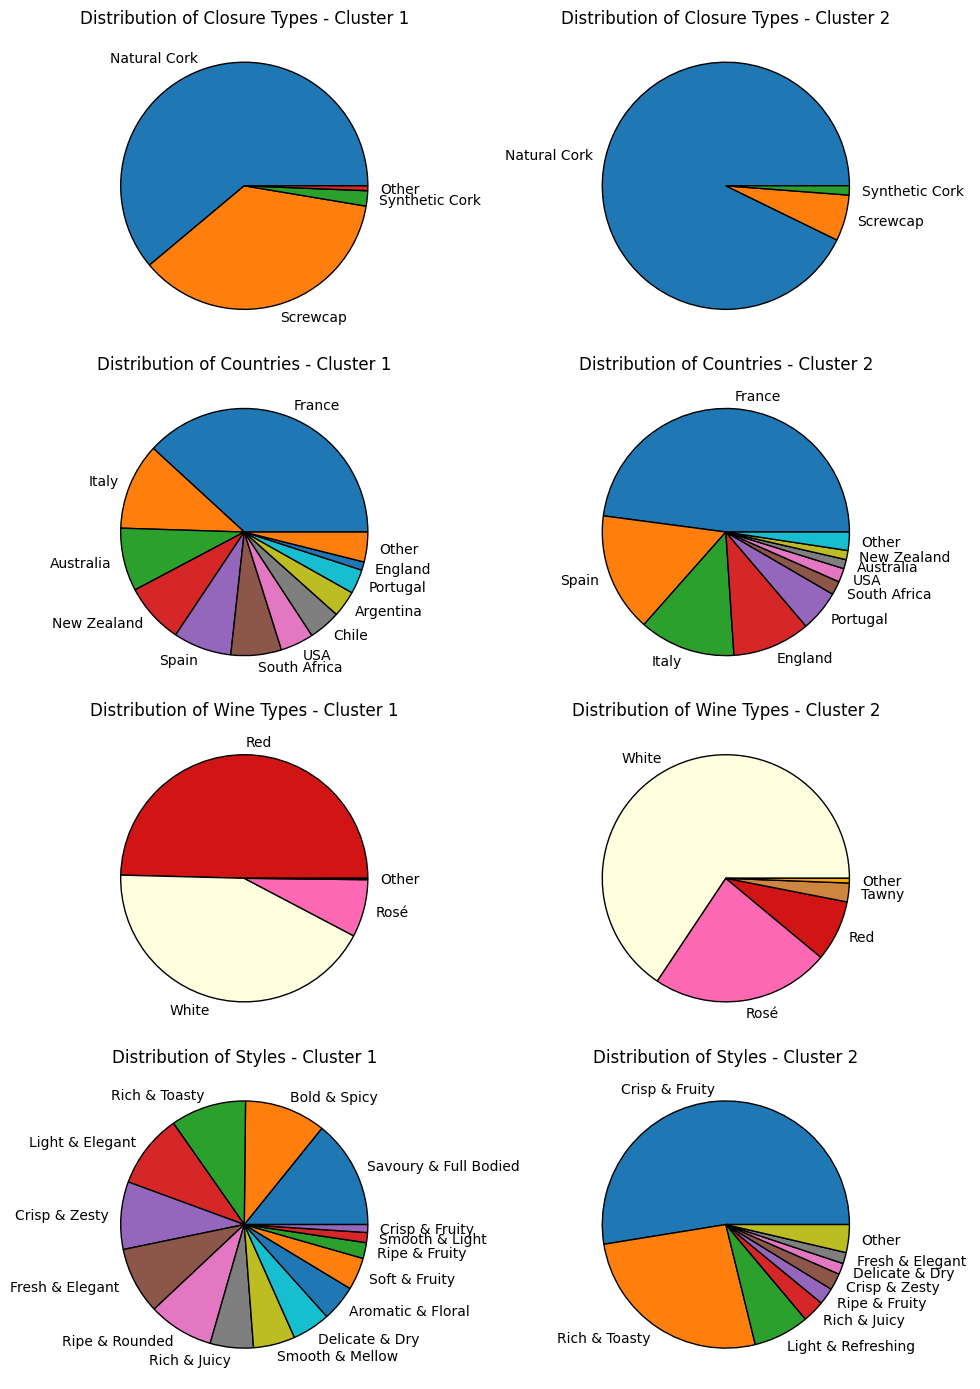

In [61]:
fig, axes = plt.subplots(4, 2, figsize = (10, 14)) # create subplot for the 2 plots

def group_others(types, threshold = 0.01): # helper function to group together categories with < 1% for label visibility
    percentages = types / types.sum()
    other = percentages[percentages < threshold].index
    if len(other) > 0:
        types['Other'] = types[other].sum()
    types = types.drop(other)
    return types
    
##########################################################################################################################################
# Closure
closure_types = cluster_1['Closure'].value_counts() # gather list of closure categories for the legend
closure_types = group_others(closure_types) # use helper function to group small categories

# closure types pie chart
closure_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = closure_types.index, ax = axes[0, 0])
axes[0, 0].set_ylabel('')
axes[0, 0].set_title('Distribution of Closure Types - Cluster 1')

closure_types = cluster_2['Closure'].value_counts() # gather list of closure categories for the legend
closure_types = group_others(closure_types) # use helper function to group small categories

# closure types pie chart
closure_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = closure_types.index, ax = axes[0, 1])
axes[0, 1].set_ylabel('')
axes[0, 1].set_title('Distribution of Closure Types - Cluster 2')

##########################################################################################################################################

# Country
country_types = cluster_1['Country'].value_counts() # gather list of countries for the legend
country_types = group_others(country_types) # use helper function to group small categories

# countries pie chart
country_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = country_types.index, ax = axes[1, 0])
axes[1, 0].set_ylabel('')
axes[1, 0].set_title('Distribution of Countries - Cluster 1')

country_types = cluster_2['Country'].value_counts() # gather list of countries for the legend
country_types = group_others(country_types) # use helper function to group small categories

# countries pie chart
country_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = country_types.index, ax = axes[1, 1])
axes[1, 1].set_ylabel('')
axes[1, 1].set_title('Distribution of Countries - Cluster 2')

##########################################################################################################################################
# Type

# list of wine colors to coordinate on plot
wine_colors = ['#D11515',  # Red
               '#FFFFE0',  # White
               '#FF69B4',  # Rosé
               '#CD853F',  # Tawny
               '#FFA500',  # Orange
               '#8B4513']  # Brown

wine_types = cluster_1['Type'].value_counts() # gather list of wine types for the legend
wine_types = group_others(wine_types) # use helper function to group small categories

# wine types pie chart
wine_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = wine_types.index, 
                               colors = wine_colors, ax = axes[2, 0])
axes[2, 0].set_ylabel('')
axes[2, 0].set_title('Distribution of Wine Types - Cluster 1')

# list of wine colors to coordinate on plot
wine_colors = ['#FFFFE0',  # White
               '#FF69B4',  # Rosé
               '#D11515',  # Red
               '#CD853F',  # Tawny
               '#FFA500',  # Orange
               '#8B4513']  # Brown

wine_types = cluster_2['Type'].value_counts() # gather list of wine types for the legend
wine_types = group_others(wine_types) # use helper function to group small categories

# wine types pie chart
wine_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = wine_types.index, 
                               colors = wine_colors, ax = axes[2, 1])
axes[2, 1].set_ylabel('')
axes[2, 1].set_title('Distribution of Wine Types - Cluster 2')

##########################################################################################################################################
# Style

style_types = cluster_1['Style'].value_counts() # gather list of styles for the legend
style_types = group_others(style_types) # use helper function to group small categories

style_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = style_types.index, ax = axes[3, 0])
axes[3, 0].set_ylabel('')
axes[3, 0].set_title('Distribution of Styles - Cluster 1')


style_types = cluster_2['Style'].value_counts() # gather list of styles for the legend
style_types = group_others(style_types) # use helper function to group small categories

style_types.plot(kind = 'pie', wedgeprops = {'edgecolor': 'black'}, labels = style_types.index, ax = axes[3, 1])
axes[3, 1].set_ylabel('')
axes[3, 1].set_title('Distribution of Styles - Cluster 2')

##########################################################################################################################################
plt.tight_layout()
#fig.suptitle('Distribution of Categorical Features')

Looking at some of the categorical features, it appears that a few of these did have a large impact on clustering. Cluster 2 seems to consist of mostly natural cork bottles, while cluster 1 has a mix of natural cork and screwcap. Countries do not seem to have played a large role in deciding the clusters. My initial prediction was that `Type` would have a large impact on the clusters, which it did. Cluster 2 is made up of mostly white wines, as well as many rosés, with only a few red wines. Cluster 1 also has white wines, but more red wines than anything else, and only a few rosés. Style also looks to be a large factors, as cluster 2 is made up of mostly 'Crisp & Fruity'. These two factors combined indicate that cluster 2 might consist of more light and fruity white wines and rosés, while cluster 1 consists of more bold, rich, full bodied red wines. 

However, a few categories don't line up with this intuition. For example, cluster 2 is made up of about 25% 'Rich & Toasty', and cluster 1 has many wines categorized as 'Light & Elegant' and 'Soft & Fruity', which seem to be in the wrong group. This could be because of the `Vintage` category, and how the model grouped all 2024 wines into cluster 2. To investigate this issue further, the `Vintage` category was removed altogether, and the same models rerun without that category. Once this feature was removed, the performance of the models dropped greatly. It also appeared that `Type` became a deciding factor, as it grouped almost all red wine in cluster 1 and almost all white and rosé in cluster 2, and resulted in an even greater imbalance in cluster sizes. Style then seemed to play a much less important role in clustering. So, I decided to keep the `Vintage` category, as it still allowed for more complexity than with it removed.
_____
### Wine Recommendations
Now that we have our clusters, as well as distances between data points, we can use this to actually recommend wines based on similarity. Although the cluster sizes were a bit uneven, the models did a good job of placing wines among the 20 dimensions, as wines close to each other display many similarities. The function below takes in a wine name that a person may like, as well as an optional parameter for a desired price limit. The function will then give the user a recommendation of a wine based on similarity to the specified wine, and under the specified price.

In [62]:
# function to find the closest wine to a specified wine
def find_closest_wine(preferred_wine_name, desired_price = None):
    idx_preferred = df_wine[df_wine['Title'] == preferred_wine_name].index[0] # find the index of the preferred wine
    preferred_wine = pca_data[idx_preferred] # get the feature vector for the preferred wine
    cluster_label = hier_labels[idx_preferred] # get the cluster label for the preferred wine
    same_cluster_indices = np.where(hier_labels == cluster_label)[0] # find all wines in the same cluster
    
    if desired_price is None: # if no desired price is specified
        valid_indices = same_cluster_indices
    else:
        # narrow down to wines under desired price
        valid_indices = same_cluster_indices[df_wine.iloc[same_cluster_indices]['Price'] <= desired_price].tolist() 
    if len(valid_indices) == 0: # if valid_indices is empty, no wines found
        print(f"Sorry, no wines found under the price of {price_threshold} in the same cluster as {preferred_wine_name}.")
        return

    # calculate the Euclidean distance between the preferred wine and all other wines in the same cluster
    distances = euclidean_distances([preferred_wine], pca_data[valid_indices])
    distances = np.delete(distances, np.argmin(distances))  # remove the distance to itself
    closest_idx = valid_indices[np.argmin(distances)] # get the index of the closest wine (excluding itself)    
    closest_wine_name = df_wine.iloc[closest_idx]['Title'] # get the name of the closest wine

    preferred_wine_details = df_wine.iloc[idx_preferred] # get info on preferred wine
    closest_wine_details = df_wine.iloc[closest_idx] # get info on closest wine

    # create a dataframe with a snapshot into each wine to see similarities and differences
    comparison_data = {
        'Category': ['Price', 'Type', 'Grape', 'Style', 'Characteristics', 'Country', 'Region'],  
        preferred_wine_name: [
            preferred_wine_details['Price'],
            preferred_wine_details['Type'],
            preferred_wine_details['Grape'],
            preferred_wine_details['Style'],
            preferred_wine_details['Characteristics'],
            preferred_wine_details['Country'],
            preferred_wine_details['Region'] 
        ],
        closest_wine_name: [
            closest_wine_details['Price'],
            closest_wine_details['Type'],
            closest_wine_details['Grape'],
            closest_wine_details['Style'],
            closest_wine_details['Characteristics'],
            closest_wine_details['Country'],
            closest_wine_details['Region']
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    
    # print the results
    print(f"\nIf you enjoy {preferred_wine_name}, you might also like {closest_wine_name}.\n")
    print("Here is a comparison of the two wines:")
    pd.set_option('display.max_colwidth', 28)
    print(comparison_df)

In [63]:
find_closest_wine('Chapel Down Brut, Kent', 10)


If you enjoy Chapel Down Brut, Kent, you might also like The Guv'nor Sparkling, Spain.

Here is a comparison of the two wines:
          Category    Chapel Down Brut, Kent The Guv'nor Sparkling, Spain
0            Price                     29.99                         9.99
1             Type                     White                        White
2            Grape                Pinot Noir                   Chardonnay
3            Style            Crisp & Fruity               Crisp & Fruity
4  Characteristics  Pear, Cream, Green Apple  Citrus Fruit, Peach, Van...
5          Country                   England                        Spain
6           Region                      Kent                          NaN


This appears to be a great recommendation, as both of these wines are white wines with similar fruit-forward profiles, and both have 'crisp & fruity' styles. The function also took into consideration the price limit that was entered and was able to find a very similar wine with this additional constraint placed. Even with missing data in a caategory (region), the model was still able to select a very similar wine.

In [64]:
find_closest_wine('Marqués de Altillo Rioja 2021')


If you enjoy Marqués de Altillo Rioja 2021, you might also like Araldica Barolo DOCG 2018/19.

Here is a comparison of the two wines:
          Category Marqués de Altillo Rioja 2021 Araldica Barolo DOCG 2018/19
0            Price                        10.99                         21.99
1             Type                          Red                           Red
2            Grape                  Tempranillo                      Nebbiolo
3            Style              Smooth & Mellow               Smooth & Mellow
4  Characteristics  Black Fruit, Red Fruit, ...       Spice, Earth, Red Fruit
5          Country                        Spain                         Italy
6           Region            Rioja And Navarra                      Piedmont


This also looks like a good recommendation. Both of these wines are red, with 'smooth & mellow' styles and both exhibit notes of red fruits, indicating a gentle, fruity flavor profile. The wines are from different years and regions, but people typically care more about the notes and flavors of wines when asking for recommandations. 

____
## Conclusion
This analysis employed several unsupervised learning methods to explore the Kaggle wine dataset and group these wines into clusters. **Word2Vec** was used in the data cleaning process to vectorize the wine descriptions, capturing semantic relationships in the text. **PCA** was then applied to reduce dimensionality, making the data more manageable and focusing on the most important features. Then, several models were trained on the PCA-reduced data. **K-Means** clustering was performed on this data, with **t-SNE** employed to visualize the clustering results. Additionally, **Hierarchical Clustering** and **DBSCAN** were explored, and all 3 clustering models used **Hyperparameter Optimization**. While the cluster sizes were uneven, the models successfully identitified meaningful groupings in the wine data, and were able to give accurate recommendations for wine based on distances within clusters. More data would likely enhance the model performance, as there were only 1270 data points, yet the methods still effectively uncovered useful patterns from the wine dataset.

______
### References
#### Kaggle Dataset
https://www.kaggle.com/datasets/elvinrustam/wine-dataset?select=WineDataset.csv

#### Calculating Alcohol Units
https://www.nhs.uk/live-well/alcohol-advice/calculating-alcohol-units/#:~:text=Calculating%20units&text=For%20example%2C%20wine%20that%20says,dividing%20the%20result%20by%201%2C000.

#### Quantile Transformation
https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.QuantileTransformer.html

#### Word2Vec
https://www.tensorflow.org/text/tutorials/word2vec

#### PCA
https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html

#### K-Means
https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html

#### AgglomerativeClustering
https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html

### DBSCAN
https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.DBSCAN.html